In [37]:
import h5py
import os
from matplotlib import image
from matplotlib import pyplot as plt
import re
import numpy as np
from ipywidgets import interact, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import morphology as ndmorph

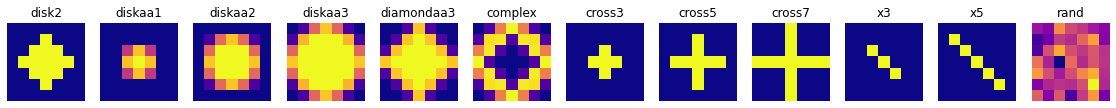

In [2]:
sel_images = os.listdir('out/selems')
plt.subplots(figsize=(200, 200))
for i, sel_image in enumerate(sel_images):
    plt.subplot(1, len(sel_images) * 10, i + 1)
    plt.imshow(image.imread('out/selems/' + sel_image))
    plt.title(sel_image[:-4])
    plt.axis('off')
plt.show()

In [3]:
dnets = [ "pconvnet_double", "lmorphnet_double", "smorphnet_double" ]
snets = [  "pconvnet", "lmorphnet", "smorphnet" ]
nets = { 2: dnets,
         1: snets }
selems = [ "cross3", "cross7", "diskaa2", "diskaa3", "diamondaa3", "complex" ]
dop = { "closing": 1,
        "opening": 0 }
sop = { "dilation": 1,
        "erosion": 0 }
ops = { 1: sop,
        2: dop }
var_names = { "pconvnet": "p",
              "lmorphnet": "p",
              "smorphnet": "alpha" }

layer_names = { "pconvnet": "pconv",
                "lmorphnet": "lm",
                "smorphnet": "sm" }

In [4]:
plot_params = { "xticks": [],
                "yticks": [] }

max_n_filter = 2 # Maximum number of filters per net
n_padding_column = 2 # Empty plots for clean labeling
global_column_size = max_n_filter + 1 # Number of columns per selem with padding

# Creating list of columns ratios, decreased size for label
# padding columns and spacing columns
width_ratios = np.ones(len(selems) * global_column_size + n_padding_column)
width_ratios[0] /= 2
width_ratios[1] /= 100
width_ratios[n_padding_column + max_n_filter::global_column_size] /= 5

In [5]:
def plot_filters(layer_name, var_name, layers, sel_idx, op, grid, fig, row, n_filters):
    neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]
    l1_name = [ x for x in layers.keys() if f"{layer_name}1" in x ][0]
    l1 = layers[f"{l1_name}/weights/filter"][()] * (-1 + 2 * neg_weights)

    start_column = n_padding_column + global_column_size * sel_idx
    column_size = 1 if n_filters == 2 else 2 

    fig.add_subplot(grid[row, start_column:start_column + column_size], **plot_params)
    plt.imshow(l1.squeeze(), cmap='plasma')
    plt.title(f"{layers[l1_name][f'weights/{var_name}'][()].squeeze():.2f}")

    if n_filters == 2:
        neg_weights = 0 if layer_name == "pconv" else neg_weights
        l2_name = [ x for x in layers.keys() if f"{layer_name}2" in x ][0]
        l2 = layers[f"{l2_name}/weights/filter"][()] * (1 - 2 * neg_weights)

        fig.add_subplot(grid[row, start_column + 1: start_column + 2], **plot_params)
        plt.imshow(l2.squeeze(), cmap='plasma')
        plt.title(f"{layers[l2_name][f'weights/{var_name}'][()].squeeze():.2f}")

In [6]:
def plot_lmorph(**kwargs):
    plot_filters("lm", "p", **kwargs)

def plot_smorph(**kwargs):
    plot_filters("sm", "alpha", **kwargs)

def plot_pconv(**kwargs):
    plot_filters("pconv", "p", **kwargs)

def print_meta(path, op, loss, n=None, current_loss=None, current_epoch=None):
    print(f"{'operation:':<15} {op}")
    with h5py.File(f"{path}/vis/meta.h5", "r") as file:
        for key in meta_details:
            print(f"{key + ':':<15} {file[key][()]}")

        print()
        print(f"{'end_epoch' + ':':<15} {file['end_epoch'][()]}")
        print(f"{'end_reason' + ':':<15} {file['end_reason'][()]}")
        print(f"{'attained loss:':<15} {loss}")
        print()
        
        if n != None:
            print(f"{'current_loss' + ': ':<15} {current_loss}")
            print(f"{'current_epoch' + ': ':<15} {current_epoch}")

In [7]:
meta_details = [ 'batch_size',
                 'dataset',
                 'loss',
                 'max_epochs',
                 'model',
                 'patience',
                 'sel_name',
                 'sel_size',
                 'vis_freq' ]

net_plots = { "lmorphnet_double": plot_lmorph,
              "pconvnet_double": plot_pconv,
              "smorphnet_double": plot_smorph,
              "lmorphnet": plot_lmorph,
              "pconvnet": plot_pconv,
              "smorphnet": plot_smorph }

In [8]:
# Creating the global grid
def init(nb_rows, coeff=2):
    fig = plt.figure(constrained_layout=False,
                     figsize=(1 + nb_rows, coeff * (n_padding_column + len(selems) * global_column_size)),
                     dpi=50)
    grid = fig.add_gridspec(nrows=1 + nb_rows,
                            ncols=n_padding_column + len(selems) * global_column_size,
                            width_ratios=width_ratios,
                            left=0, right=2)

    # Filling selem row
    for i, sel_image in enumerate(selems):
        left_border = n_padding_column + i * global_column_size
        right_border = left_border + max_n_filter
        fig.add_subplot(grid[0, left_border:right_border], **plot_params)
        plt.imshow(image.imread(f"out/selems/{sel_image}.png"))
        plt.title(sel_image)

    params = { "grid": grid,
               "fig": fig,
               "row": 1 }
    
    return fig, grid, params

In [9]:
def plot(net_list, row, params, n_filters, run=0):
    params["n_filters"] = n_filters

    for net in net_list:
        fig.add_subplot(grid[row:row + len(ops[n_filters].keys()), 0],
                        frameon=False,
                        **plot_params)
        plt.ylabel(net, fontweight='bold', fontsize=20)

        for op in ops[n_filters].keys():
            params["op"] = op

            fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
            plt.ylabel(op, fontsize=15)
            for sel_idx, sel in enumerate(selems):
                path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
                n_batches = len(os.listdir(f"{path}/vis/batches/"))

                with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                    #print_meta(path, op, file['logs/loss'][()])
                    net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

            row += 1
            params["row"] = row

    return row, params

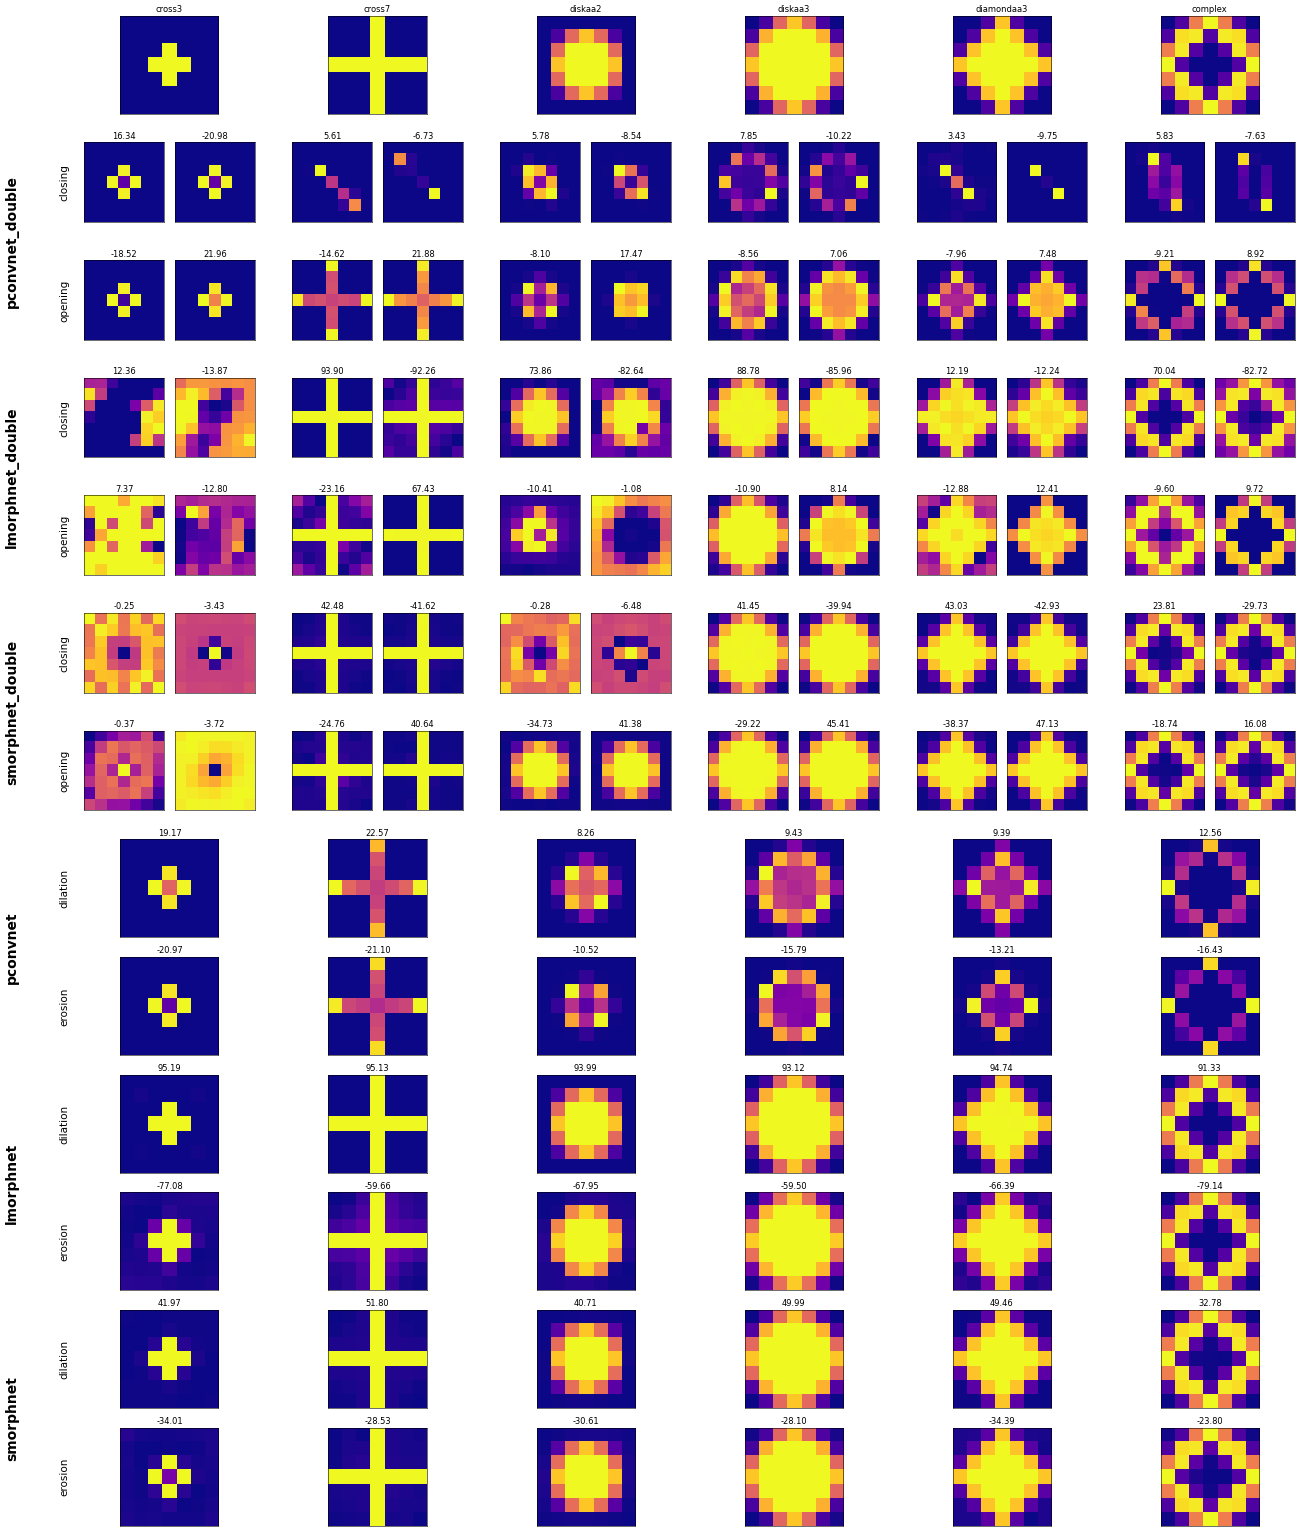

In [10]:
fig, grid, params = init(len(dnets) * len(dop) + len(snets) * len(sop))

row = 1

for n_filters, net_list in nets.items():
    row, params = plot(net_list, row, params, n_filters, 9)

plt.show()

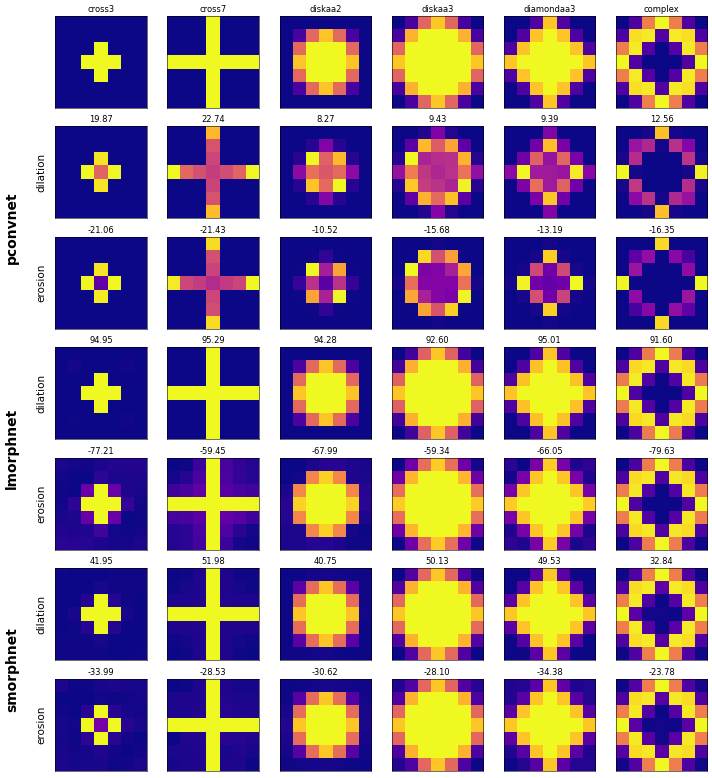

In [11]:
fig, grid, params = init(len(snets) * len(sop), coeff=1)

plot(snets, 1, params, 1)

plt.show()

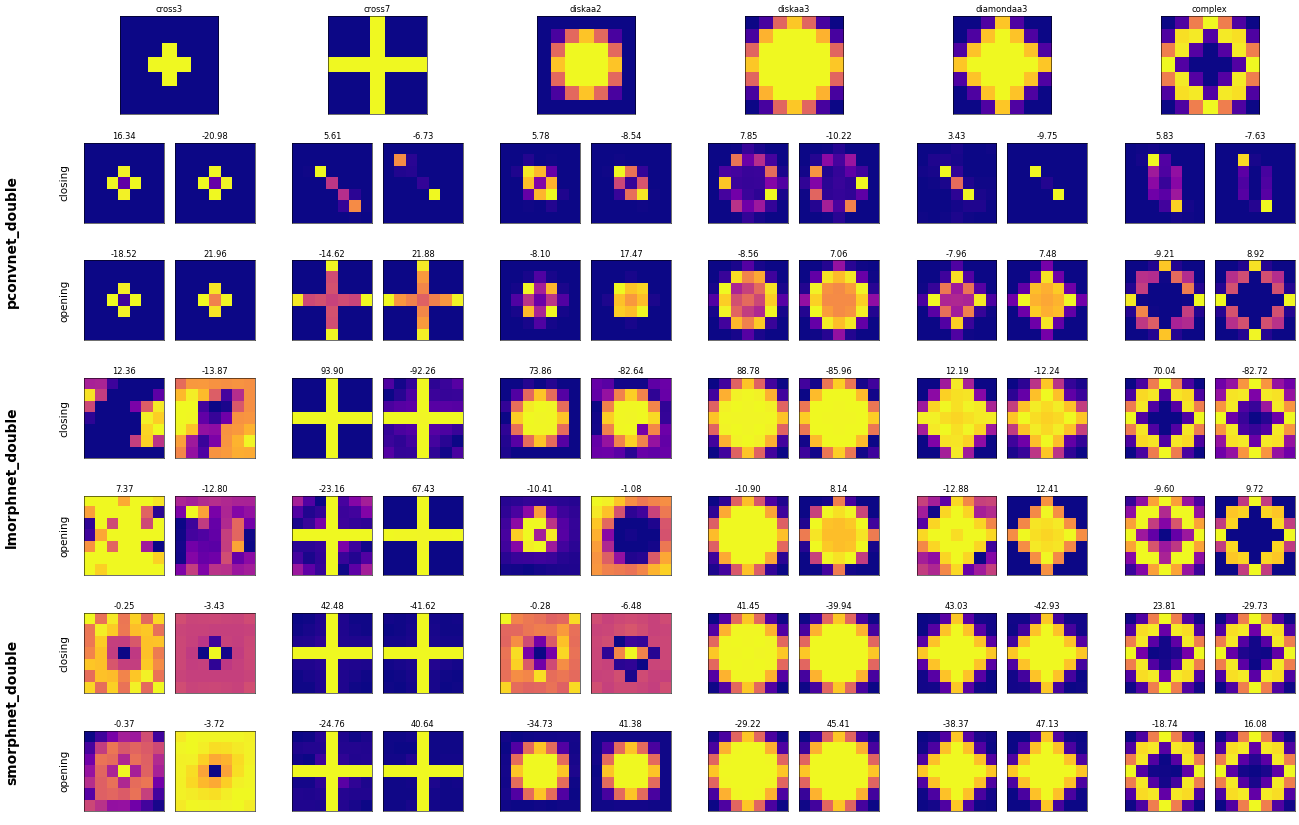

In [323]:
fig, grid, params = init(2 * (len(dnets) * len(dop)))

plot(dnets, 1, params, 2, 9)

plt.show()

In [17]:
def update(x, n_filters, op, var_name, layer_name, path):
    fig = plt.figure()
    with h5py.File(f"{path}/vis/batches/{x:06}.h5", "r") as file:
        neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]
        l1_name = [ x for x in file['layers'].keys() if f"{layer_name}1" in x ][0]
        l1 = file['layers'][f"{l1_name}/weights/filter"][()] * (-1 + 2 * neg_weights)

        ax = fig.add_subplot(1, n_filters, 1)
        p = ax.imshow(l1.squeeze(), cmap='plasma')
        ax.set_title(f"{file['layers'][l1_name][f'weights/{var_name}'][()].squeeze():.2f}")
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(p, cax=cax)

        if n_filters == 2:
            neg_weights = 0 if layer_name == "pconv" else neg_weights
            l2_name = [ x for x in file['layers'].keys() if f"{layer_name}2" in x ][0]
            l2 = file['layers'][f"{l2_name}/weights/filter"][()] * (1 - 2 * neg_weights)

            ax = fig.add_subplot(1, 2, 2)
            p = ax.imshow(l2.squeeze(), cmap='plasma')
            plt.title(f"{file['layers'][l2_name][f'weights/{var_name}'][()].squeeze():.2f}")
            ax.axis('off')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(p, cax=cax)

        plt.show()

        sb1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
        print(f"bias: {file['layers'][f'{sb1_name}/weights/bias'][()].squeeze()}")
        print(f"weight: {file['layers'][f'{sb1_name}/weights/weight'][()].squeeze()}")
        if x != 0:
            print(f"loss: {file['logs/loss'][()].squeeze()}")
        else:
            print(f"loss: inf")

def evolution(run, net, op, sel):
    path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
    n_batches = len(os.listdir(f"{path}/vis/batches/"))

    kwargs = { "n_filters": 1 if net in snets else 2,
               "op": op,
               "var_name": [ name for n, name in var_names.items() if n in net ][0],
               "layer_name": [ name for n, name in layer_names.items() if n in net ][0],
               "path": path }
    
    interact(lambda x : update(x, **kwargs), x=widgets.IntSlider(min=0, max=n_batches - 1, step=1, value=0))

In [22]:
evolution(5, "lmorphnet", "erosion", "complex")

interactive(children=(IntSlider(value=0, description='x', max=11610), Output()), _dom_classes=('widget-interac…

In [174]:
def get_info(run, net, op, sel, n=None):
        path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
        n_batches = len(os.listdir(f"{path}/vis/batches/"))

        with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            loss = file['logs/loss'][()]
            if n == None:
                print_meta(path, op, loss)
                return

        with h5py.File(f"{path}/vis/batches/{n:06}.h5", "r") as file:
            print_meta(path, op, loss, n, file['logs/loss'][()], file['logs/current_epoch'][()] - 1)

In [324]:
get_info(12, "smorphnet_double", "opening", "diskaa3")

operation:      opening
batch_size:     32
dataset:        mnist
end_epoch:      41
end_reason:     No improvement to validation loss in 10 epochs, terminating.
loss:           mse
max_epochs:     1000
model:          models.smorphnet_double
patience:       10
sel_name:       diskaa3
sel_size:       7
vis_freq:       125

end_epoch:      41
end_reason:     No improvement to validation loss in 10 epochs, terminating.
attained loss:  6.630266736603923e-07



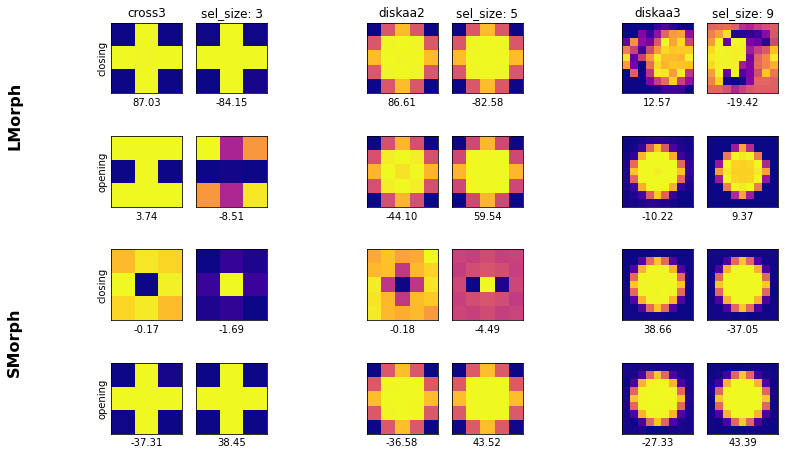

In [316]:
run = 17

plt.subplots(figsize=(15, 8))
plt.subplot(4, 10, 1, frameon=False, **plot_params)
plt.ylabel("LMorph", weight='bold', y=-0.1, size=16)
plt.subplot(4, 10, 21, frameon=False, **plot_params)
plt.ylabel("SMorph", weight='bold', y=-0.1, size=16)
for j, (net, lname, opname) in enumerate([("lmorphnet_double", "lm", "p"), ("smorphnet_double", "sm", "alpha")]):
    for i, (op, neg_weights) in enumerate(dop.items()):
        n_batches = len(os.listdir(f"out/mnist_{net}_mse_{op}_cross3_{run}/vis/batches/"))
        with h5py.File(f"out/mnist_{net}_mse_{op}_cross3_{run}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            plt.subplot(4, 10, 2 + (i + 2 * j) * 10, **plot_params)
            plt.ylabel(op)
            plt.xlabel(f"{file['layers'][f'000_{lname}1/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                plt.title("cross3")
            plt.imshow((file['layers'][f"000_{lname}1/weights/filter"][()] * (-1 + 2 * neg_weights)).squeeze(), cmap='plasma')
            plt.subplot(4, 10, 3 + (i + 2 * j) * 10, **plot_params)
            plt.xlabel(f"{file['layers'][f'001_{lname}2/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                with h5py.File(f"out/mnist_{net}_mse_{op}_cross3_{run}/vis/meta.h5", "r") as f:
                    plt.title(f"sel_size: {f['sel_size'][()]}")
            plt.imshow((file['layers'][f"001_{lname}2/weights/filter"][()] * (1 - 2 * neg_weights)).squeeze(), cmap='plasma')

        n_batches = len(os.listdir(f"out/mnist_{net}_mse_{op}_diskaa2_{run}/vis/batches/"))
        with h5py.File(f"out/mnist_{net}_mse_{op}_diskaa2_{run}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            plt.subplot(4, 10, 5 + (i + 2 * j) * 10, **plot_params)
            plt.xlabel(f"{file['layers'][f'000_{lname}1/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                plt.title("diskaa2")
            plt.imshow((file['layers'][f"000_{lname}1/weights/filter"][()] * (-1 + 2 * neg_weights)).squeeze(), cmap='plasma')
            plt.subplot(4, 10, 6 + (i + 2 * j) * 10, **plot_params)
            plt.xlabel(f"{file['layers'][f'001_{lname}2/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                with h5py.File(f"out/mnist_{net}_mse_{op}_diskaa2_{run}/vis/meta.h5", "r") as f:
                    plt.title(f"sel_size: {f['sel_size'][()]}")
            plt.imshow((file['layers'][f"001_{lname}2/weights/filter"][()] * (1 - 2 * neg_weights)).squeeze(), cmap='plasma')
            
        n_batches = len(os.listdir(f"out/mnist_{net}_mse_{op}_diskaa3_{run}/vis/batches/"))
        with h5py.File(f"out/mnist_{net}_mse_{op}_diskaa3_{run}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            plt.subplot(4, 10, 8 + (i + 2 * j) * 10, **plot_params)
            plt.xlabel(f"{file['layers'][f'000_{lname}1/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                plt.title("diskaa3")
            plt.imshow((file['layers'][f"000_{lname}1/weights/filter"][()] * (-1 + 2 * neg_weights)).squeeze(), cmap='plasma')
            plt.subplot(4, 10, 9 + (i + 2 * j) * 10, **plot_params)
            plt.xlabel(f"{file['layers'][f'001_{lname}2/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                with h5py.File(f"out/mnist_{net}_mse_{op}_diskaa3_{run}/vis/meta.h5", "r") as f:
                    plt.title(f"sel_size: {f['sel_size'][()]}")
            plt.imshow((file['layers'][f"001_{lname}2/weights/filter"][()] * (1 - 2 * neg_weights)).squeeze(), cmap='plasma')

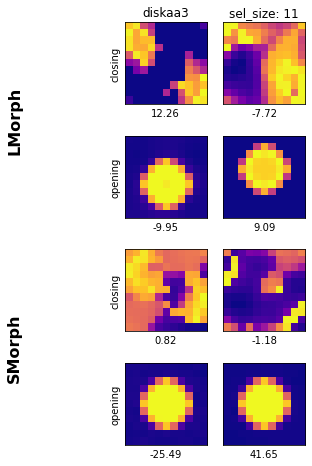

In [343]:
run = 18
selem = "diskaa3"

plt.subplots(figsize=(5, 8))
plt.subplot(4, 3, 1, frameon=False, **plot_params)
plt.ylabel("LMorph", weight='bold', y=-0.1, size=16)
plt.subplot(4, 3, 7, frameon=False, **plot_params)
plt.ylabel("SMorph", weight='bold', y=-0.1, size=16)
for j, (net, lname, opname) in enumerate([("lmorphnet_double", "lm", "p"), ("smorphnet_double", "sm", "alpha")]):
    for i, (op, neg_weights) in enumerate(dop.items()):
        n_batches = len(os.listdir(f"out/mnist_{net}_mse_{op}_{selem}_{run}/vis/batches/"))
        with h5py.File(f"out/mnist_{net}_mse_{op}_{selem}_{run}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            plt.subplot(4, 3, 2 + (i + 2 * j) * 3, **plot_params)
            plt.xlabel(f"{file['layers'][f'000_{lname}1/weights/{opname}'][()].squeeze():.2f}")
            plt.ylabel(op)
            if i + j == 0:
                plt.title(selem)
            plt.imshow((file['layers'][f"000_{lname}1/weights/filter"][()] * (-1 + 2 * neg_weights)).squeeze(), cmap='plasma')
            plt.subplot(4, 3, 3 + (i + 2 * j) * 3, **plot_params)
            plt.xlabel(f"{file['layers'][f'001_{lname}2/weights/{opname}'][()].squeeze():.2f}")
            if i + j == 0:
                with h5py.File(f"out/mnist_{net}_mse_{op}_{selem}_{run}/vis/meta.h5", "r") as f:
                    plt.title(f"sel_size: {f['sel_size'][()]}")
            plt.imshow((file['layers'][f"001_{lname}2/weights/filter"][()] * (1 - 2 * neg_weights)).squeeze(), cmap='plasma')

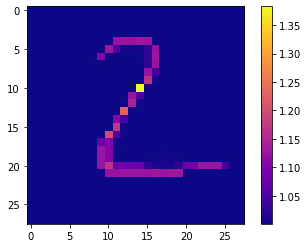

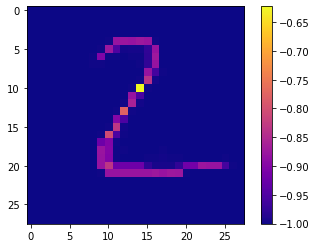

In [426]:
n_batches = len(os.listdir("out/mnist_lmorphnet_mse_erosion_diskaa2_0/vis/batches/"))
with h5py.File(f"out/mnist_lmorphnet_mse_erosion_diskaa2_0/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    plt.imshow(file['layers/000_lm1/output'][()][1,0,:,:], cmap='plasma')
    plt.colorbar()
    plt.show()
    plt.imshow(file['layers/001_sb1/output'][()][1,0,:,:], cmap='plasma')
    plt.colorbar()

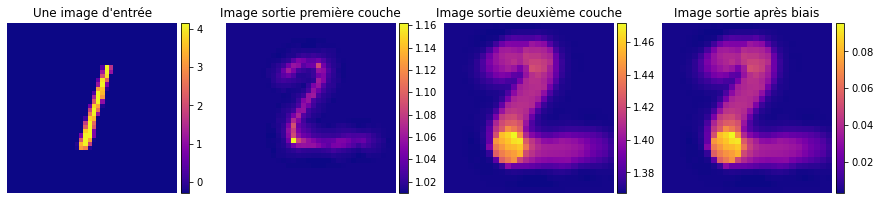

In [432]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(15, 10))
with h5py.File(f"out/mnist_lmorphnet_double_mse_opening_diskaa3_2/vis/meta.h5", "r") as file:
    ax = fig.add_subplot(141)
    p = ax.imshow(file['inputs'][()][2].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('Une image d\'entrée')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
n_batches = len(os.listdir("out/mnist_lmorphnet_double_mse_opening_diskaa3_2/vis/batches/"))
with h5py.File(f"out/mnist_lmorphnet_double_mse_opening_diskaa3_2/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    ax = fig.add_subplot(142)
    p = ax.imshow(file['layers/000_lm1/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie première couche')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(143)
    p = ax.imshow(file['layers/001_lm2/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie deuxième couche')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(144)
    p = ax.imshow(file['layers/002_sb1/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie après biais')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

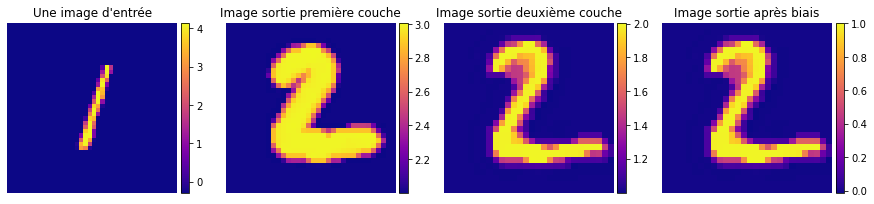

In [427]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(15, 10))
with h5py.File(f"out/mnist_lmorphnet_double_mse_opening_diskaa2_0/vis/meta.h5", "r") as file:
    ax = fig.add_subplot(141)
    p = ax.imshow(file['inputs'][()][2].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('Une image d\'entrée')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
n_batches = len(os.listdir("out/mnist_lmorphnet_double_mse_closing_diskaa2_0/vis/batches/"))
with h5py.File(f"out/mnist_lmorphnet_double_mse_closing_diskaa2_0/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    ax = fig.add_subplot(142)
    p = ax.imshow(file['layers/000_lm1/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie première couche')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(143)
    p = ax.imshow(file['layers/001_lm2/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie deuxième couche')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(144)
    p = ax.imshow(file['layers/002_sb1/output'][()][1,0,:,:], cmap='plasma')
    ax.axis('off')
    ax.set_title('Image sortie après biais')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

In [473]:
def center_in(arr, shape, dtype="float32"):
    res = np.zeros(shape=shape, dtype=dtype)
    pad_before = (shape[0] - arr.shape[0]) // 2, (shape[1] - arr.shape[1]) // 2
    pad_after = shape[0] - pad_before[0], shape[1] - pad_before[1]
    res[pad_before[0] : pad_after[0], pad_before[1] : pad_after[1]] = arr
    return res

def draw_disk(radius, shape=None, dtype="float32"):
    from skimage import morphology
 
    res = morphology.disk(radius).astype(dtype)
    if shape is not None:
        return center_in(res, shape)

    return res

def shape_aa(original, target_shape):
    from skimage import transform

    return transform.resize(
         original, target_shape, preserve_range=True, anti_aliasing=True
    )

def draw_disk_aa(radius, shape=None, dtype="float32"):
    from skimage import transform
    dim = radius * 2 + 1
    res = draw_disk(dim, dtype=dtype)
    res = shape_aa(res, (dim, dim))

    if shape is not None:
        return center_in(res, shape)
    return res

W: [0.0; 1.1025574616196665]


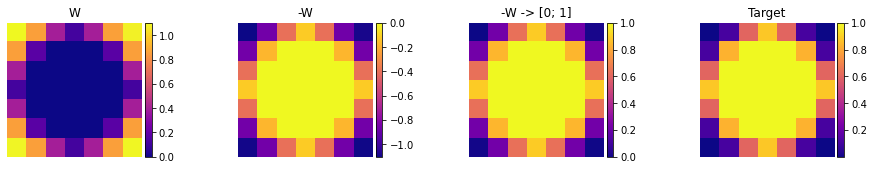

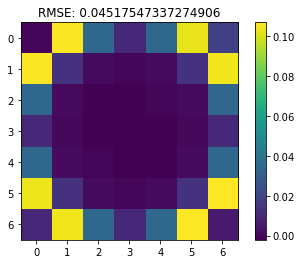

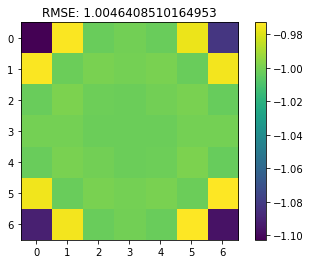

In [495]:
n_batches = len(os.listdir("out/mnist_lmorphnet_mse_erosion_diskaa3_7/vis/batches/"))
fig = plt.figure(figsize=(15, 15))
with h5py.File(f"out/mnist_lmorphnet_mse_erosion_diskaa3_7/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    print(f"W: [{np.min(file['layers/000_lm1/weights/filter'][()].squeeze())}; {np.max(file['layers/000_lm1/weights/filter'][()].squeeze())}]")
    ax = fig.add_subplot(141)
    p = plt.imshow(file['layers/000_lm1/weights/filter'][()].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('W')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
      
    ax = fig.add_subplot(142)
    p = plt.imshow(-file['layers/000_lm1/weights/filter'][()].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('-W')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    filt = -file['layers/000_lm1/weights/filter'][()].squeeze()
    filt -= np.min(filt)
    filt /= np.max(filt)
    ax = fig.add_subplot(143)
    p = plt.imshow(filt, cmap='plasma')
    ax.axis('off')
    ax.set_title('-W -> [0; 1]')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    sel = draw_disk_aa(3, (7, 7))
    ax = fig.add_subplot(144)
    p = plt.imshow(sel, cmap='plasma')
    ax.axis('off')
    ax.set_title('Target')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    plt.subplots_adjust(wspace=0.6)
    plt.show()

    plt.imshow(filt - sel)
    plt.colorbar()
    plt.title(f"RMSE: {np.sqrt(np.sum((filt - sel)**2) / (filt.shape[0] * filt.shape[1]))}")
    plt.show()
    
    filt = -file['layers/000_lm1/weights/filter'][()].squeeze()
    plt.imshow(filt - sel)
    plt.colorbar()
    plt.title(f"RMSE: {np.sqrt(np.sum((filt - sel)**2) / (filt.shape[0] * filt.shape[1]))}")

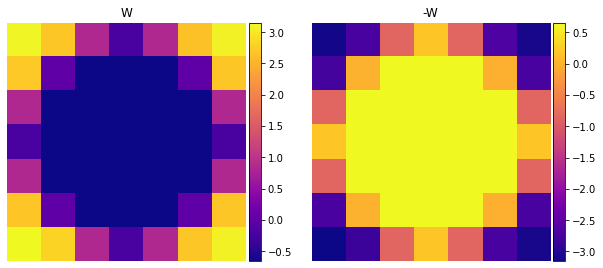

In [450]:
n_batches = len(os.listdir("out/mnist_smorphnet_mse_erosion_diskaa3_9/vis/batches/"))
fig = plt.figure(figsize=(10, 10))
with h5py.File(f"out/mnist_smorphnet_mse_erosion_diskaa3_9/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    ax = fig.add_subplot(121)
    p = plt.imshow(file['layers/000_sm1/weights/filter'][()].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('W')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
      
    ax = fig.add_subplot(122)
    p = plt.imshow(-file['layers/000_sm1/weights/filter'][()].squeeze(), cmap='plasma')
    ax.axis('off')
    ax.set_title('-W')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

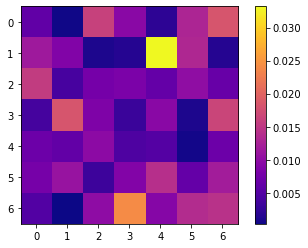

0.0002944284592241846


In [503]:
with h5py.File(f"out/mnist_lmorphnet_mse_erosion_diskaa2_2/vis/batches/{0:06}.h5", "r") as file:
    plt.imshow(file['layers/000_lm1/weights/filter'][()].squeeze(), cmap='plasma')
    plt.colorbar()
    plt.show()
    print(np.min(file['layers/000_lm1/weights/filter'][()].squeeze()))

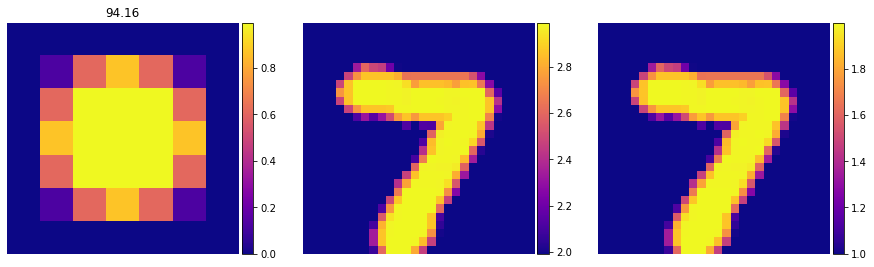

bias: -0.9988696562440007
weight: 1.0030667951578043
loss: 7.6001918846489326e-06
<HDF5 dataset "output": shape (10, 1, 28, 28), type "<f8">


In [65]:
net = "lmorphnet"
layer_name = "lm"
var_name = "p"
op = "dilation"
sel = "diskaa2"
run = 1

path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
n_batches = len(os.listdir(f"{path}/vis/batches/"))

fig = plt.figure(figsize=(15,15))
with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    l1_name = [ x for x in file['layers'].keys() if f"{layer_name}1" in x ][0]
    l1 = file['layers'][f"{l1_name}/weights/filter"][()] * 1

    ax = fig.add_subplot(131)
    p = ax.imshow(l1.squeeze(), cmap='plasma')
    ax.set_title(f"{file['layers'][l1_name][f'weights/{var_name}'][()].squeeze():.2f}")
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

    ax = fig.add_subplot(132)
    p = ax.imshow(file['layers'][l1_name]["output"][()].squeeze()[0], cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    sb1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
    ax = fig.add_subplot(133)
    p = ax.imshow(file['layers'][sb1_name]["output"][()].squeeze()[0], cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    plt.show()

    
    print(f"bias: {file['layers'][f'{sb1_name}/weights/bias'][()].squeeze()}")
    print(f"weight: {file['layers'][f'{sb1_name}/weights/weight'][()].squeeze()}")
    print(f"loss: {file['logs/loss'][()].squeeze()}")
    print(file['layers'][sb1_name]["output"])

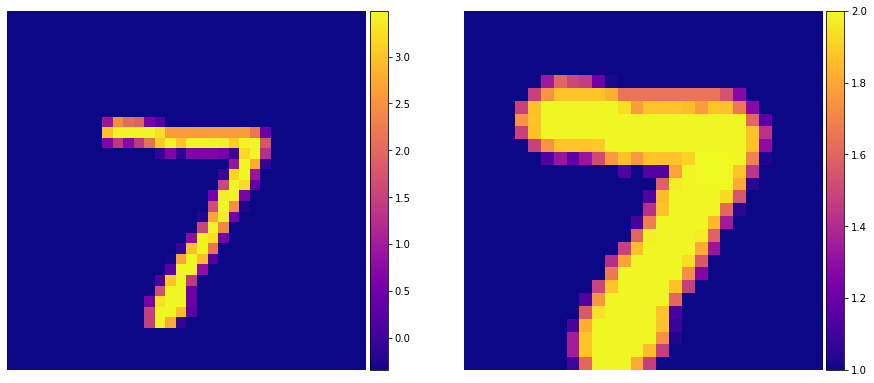

In [67]:
fig = plt.figure(figsize=(15,15))
with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    ax = fig.add_subplot(121)
    p = ax.imshow(file["inputs"][()].squeeze()[0], cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

    ax = fig.add_subplot(122)
    p = ax.imshow(file["targets"][()].squeeze()[0], cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

In [61]:
sel = draw_disk_aa(3, (7, 7))

NameError: name 'draw_disk_aa' is not defined

min: 0.0
max: 0.993885997995876


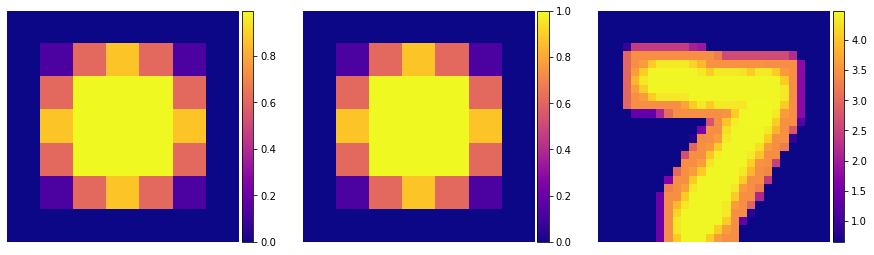

In [74]:
n_batches = len(os.listdir(f"{path}/vis/batches/"))
fig = plt.figure(figsize=(15, 15))
with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    l1_name = [ x for x in file['layers'].keys() if f"{layer_name}1" in x ][0]
    l1 = file['layers'][f"{l1_name}/weights/filter"][()] * 1

    print("min:", np.min(l1))
    print("max:", np.max(l1))
    
    ax = fig.add_subplot(131)
    p = ax.imshow(l1.squeeze(), cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(132)
    p = ax.imshow(l1.squeeze() / np.max(l1), cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    with h5py.File(f"{path}/vis/meta.h5", "r") as file2:
        crop_h, crop_w = 7 // 2, 7 // 2
        res = ndmorph.grey_dilation(file2["inputs"][()].squeeze()[0], structure=l1.squeeze())[
            crop_h : file2["inputs"][()].squeeze()[0].shape[0] - crop_h, crop_w : file2["inputs"][()].squeeze()[0].shape[1] - crop_w
        ]

        ax = fig.add_subplot(133)
        p = ax.imshow(res, cmap='plasma')
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(p, cax=cax)